In [1]:
from posteriordb import PosteriorDatabase
import os
import json
import bridgestan as bs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stein_thinning.stein import ksd
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_centkgm

from stein_pi_thinning.target import PiTargetCentKGM
from stein_pi_thinning.mcmc import mala_adapt
from stein_pi_thinning.util import flat
from stein_pi_thinning.progress_bar import disable_progress_bar

import wasserstein


np.random.seed(1234)
disable_progress_bar()

### Model Preparation

In [2]:
# Load DataBase Locally
pdb_path = os.path.join("../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("arma-arma11")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

In [3]:
# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s

gs_matrix = np.array([df.values[0,i] for i in range(df.shape[1])]).T

### P Target and Q Target

In [4]:
# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [5]:
# Construct log-Pi-pdf and its gradient
# Using Centralised KGM kernel
# linv is -Hessian Matrix at P mode

# Stein Centralised KGM kernel
dim = model.param_num()
x_unconstrain_map = model.param_unconstrain(np.mean(gs_chains, axis=1))
linv = -hess_log_p(x_unconstrain_map)
s = 3.0

stein_q_kgm = PiTargetCentKGM(log_p, grad_log_p, hess_log_p, linv, s, x_unconstrain_map)
log_q = stein_q_kgm.log_q
grad_log_q = stein_q_kgm.grad_log_q

In [6]:
# MALA With pre-conditioning
# Parameters
nits = 100_000 # the number of iterations

alpha = 10 * [1]
epoch = 9 * [1_000] + [nits]

_, _, x_p_epoch, _, _, nacc_p = mala_adapt(log_p, grad_log_p, x_unconstrain_map, 1, np.eye(dim), alpha, epoch)
print('acc_p =', np.mean(nacc_p[-1]))

/home/congye/Software/anaconda3/envs/stein-q-thinning/lib/python3.10/site-packages/scipy/stats/_multivariate.py:530: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(cov_object.whiten(dev)), axis=-1)


acc_p = 0.59691


In [7]:
_, _, x_q_epoch, _, _, nacc_q = mala_adapt(log_q, grad_log_q, x_unconstrain_map, 1, np.eye(dim), alpha, epoch)
print('acc_q =', np.mean(nacc_q[-1]))

/home/congye/Code/PythonProjects/Stein-Pi-Thinning/stein_pi_thinning/target.py:444: RuntimeWarning: overflow encountered in matmul
  return c2 + 2*c1@self.grad_log_p(x) + c0*self.grad_log_p(x)@self.grad_log_p(x)
/home/congye/Code/PythonProjects/Stein-Pi-Thinning/stein_pi_thinning/target.py:462: RuntimeWarning: overflow encountered in multiply
  2 * self.hess_log_p(x) @ c1 + grad_c0 * (self.grad_log_p(x)@self.grad_log_p(x)) +\
/home/congye/Code/PythonProjects/Stein-Pi-Thinning/stein_pi_thinning/target.py:463: RuntimeWarning: overflow encountered in matmul
  2 * c0 * self.hess_log_p(x)@self.grad_log_p(x)
/home/congye/Code/PythonProjects/Stein-Pi-Thinning/stein_pi_thinning/target.py:461: RuntimeWarning: invalid value encountered in add
  return grad_c2 + 2 * grad_c1@self.grad_log_p(x) +\
/home/congye/Code/PythonProjects/Stein-Pi-Thinning/stein_pi_thinning/target.py:277: RuntimeWarning: invalid value encountered in divide
  return 0.5 * self.grad_stein_kernel(x)/self.stein_kernel(x) + self

acc_q = 0.54632


In [8]:
x_p_unconstrain = np.array(x_p_epoch[-1], dtype=np.float64)
grad_x_p_unconstrain = np.array([grad_log_p(i) for i in x_p_unconstrain])

x_q_unconstrain = np.array(x_q_epoch[-1], dtype=np.float64)
grad_x_q_unconstrain = np.array([grad_log_p(i) for i in x_q_unconstrain])

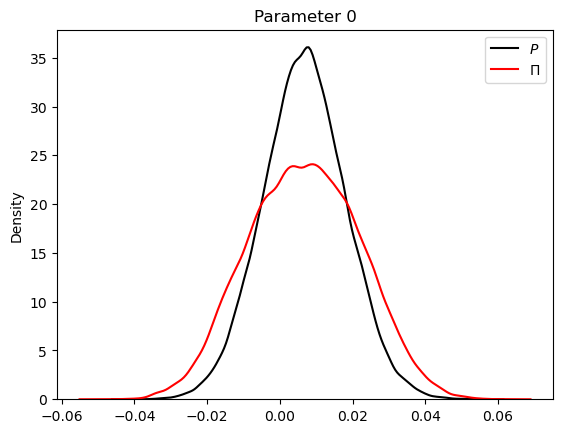

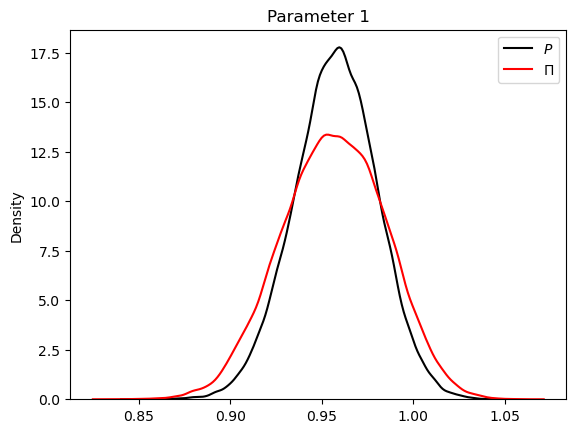

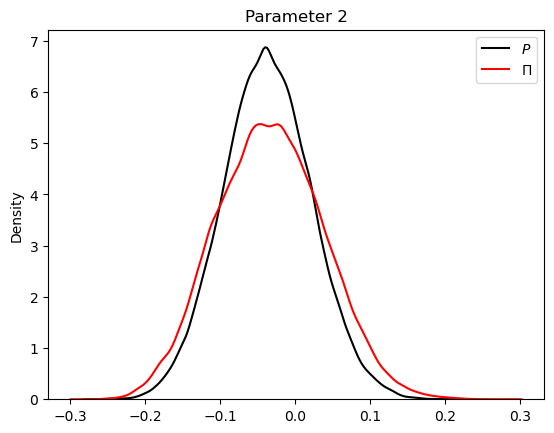

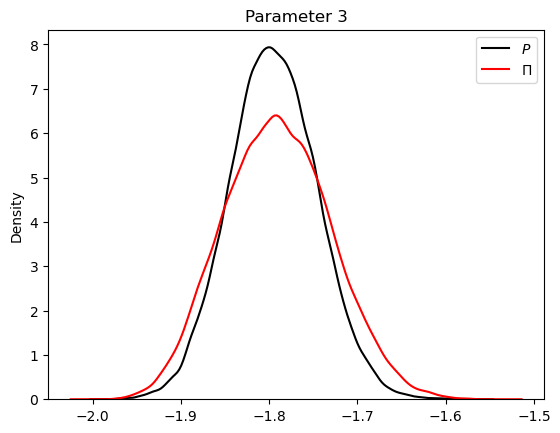

In [9]:
for i in range(dim):
    # plt.hist(x_p_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='p')
    # plt.hist(x_q_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='q')
    sns.kdeplot(x_p_unconstrain[:,i].flatten(), label='$P$', color="black")
    sns.kdeplot(x_q_unconstrain[:,i].flatten(), label='$\Pi$', color="red")

    plt.title(f"Parameter {i}")
    plt.legend()
    plt.show()

### Thinning

In [10]:
fixed_ratio = 0.1
iteration_list = [10, 20, 50, 100, 200, 500, 1000, 2000]

#IMQ
vfk0_imq = make_imq(x_p_unconstrain, grad_x_p_unconstrain, pre=linv)

res_ksd_p_imq = []
res_ksd_q_imq = []
res_ksd_p_thinning_imq = []
res_ksd_q_thinning_imq = []

In [11]:
# IMQ Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_imq)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_imq)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_imq)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_imq)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_imq.append(ks_p[-1])
    res_ksd_q_imq.append(ks_q[-1])

    res_ksd_p_thinning_imq.append(ks_p_thinning[-1])
    res_ksd_q_thinning_imq.append(ks_q_thinning[-1])

10 107.74925408924405
10 141.71358193108742
20 80.88257706561077
20 131.14801878224665
50 48.03668565584815
50 96.08945239813184
100 32.33209678557452
100 72.53078301606831
200 21.558465973457952
200 53.479651693150174
500 12.263095282413621
500 29.69714996151271
1000 7.737046364425291
1000 27.942629095944017
2000 4.940805926237144
2000 17.06541627355135


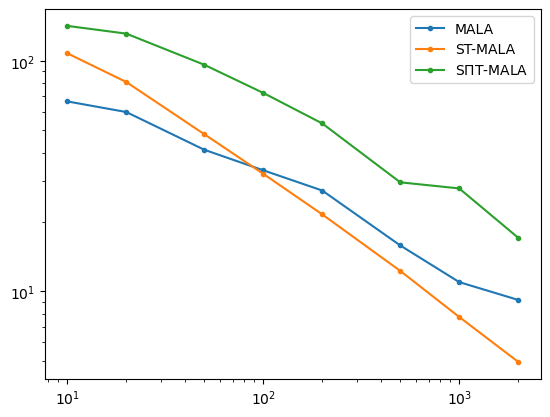

In [12]:
plt.loglog(iteration_list, res_ksd_p_imq, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_imq, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [13]:
#KGM
vfk0_centkgm = make_centkgm(x_p_unconstrain, grad_x_p_unconstrain, x_map=x_unconstrain_map, pre=linv, s=s)

res_ksd_p_centkgm = []
res_ksd_q_centkgm = []
res_ksd_p_thinning_centkgm = []
res_ksd_q_thinning_centkgm = []

In [14]:
# KGM Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    # print(f"No.{i} Index Calculation Begin")

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_centkgm)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_centkgm)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_centkgm)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_centkgm)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_centkgm.append(ks_p[-1])
    res_ksd_q_centkgm.append(ks_q[-1])

    res_ksd_p_thinning_centkgm.append(ks_p_thinning[-1])
    res_ksd_q_thinning_centkgm.append(ks_q_thinning[-1])

10 370.8061394261057
10 673.5502620301596
20 214.17844085396243
20 2453.713906391092
50 124.74277393774307
50 602.1006539252888
100 103.04115807328704
100 450.8731526454857
200 73.96641619189467
200 843.1738660246225
500 51.970277253913395
500 336.351558535106
1000 39.382285800277046
1000 240.5641983725819
2000 29.539774685788885
2000 178.17141738272625


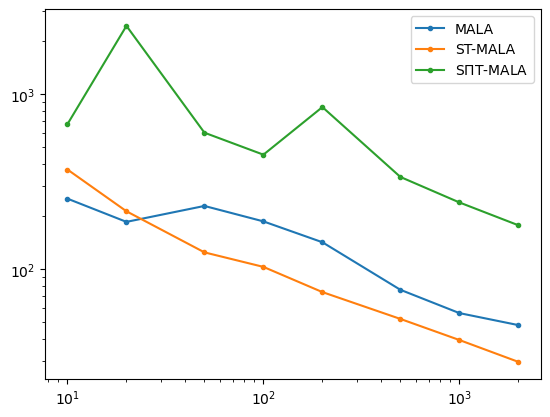

In [15]:
plt.loglog(iteration_list, res_ksd_p_centkgm, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_centkgm, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

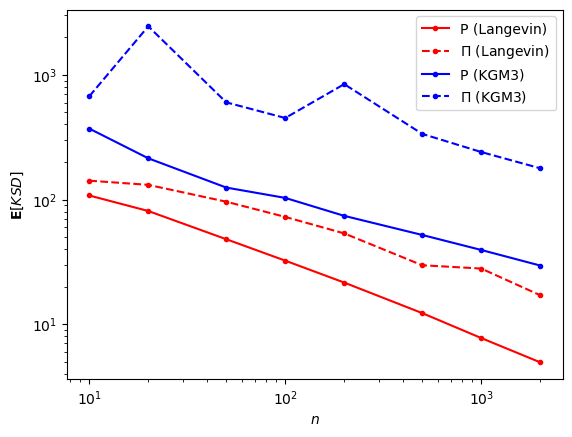

In [16]:
plt.loglog(iteration_list, res_ksd_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$KSD$]')
plt.legend()

### WasserStein

In [17]:
gs = np.zeros_like(gs_chains.T)
# gs = np.zeros_like(gs_matrix)

for i in range(gs_chains.T.shape[0]):
    gs[i] = model.param_unconstrain(gs_chains.T[i].astype(np.float64))
# for i in range(gs_matrix.shape[0]):
#     gs[i] = model.param_unconstrain(gs_matrix[i].astype(np.float64))
emd = wasserstein.EMD(n_iter_max=1_000_000)
gs_weights = np.repeat(1/gs.shape[0], gs.shape[0])

In [18]:
#IMQ
res_wass_p_imq = []
res_wass_q_imq = []
res_wass_p_thinning_imq = []
res_wass_q_thinning_imq = []

In [19]:
# IMQ Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_imq.append(wass_p)
    res_wass_q_imq.append(wass_q)

    res_wass_p_thinning_imq.append(wass_p_thinning)
    res_wass_q_thinning_imq.append(wass_q_thinning)

10 0.10799494790009936
10 0.1141921837120562
20 0.09420572851069459
20 0.11339030517636867
50 0.06191440920173679
50 0.09874471078287565
100 0.061669364698190905
100 0.08484630885283127
200 0.04762732824070771
200 0.0691378281446665
500 0.034418654529717055
500 0.05236672905814906
1000 0.02620006196095347
1000 0.04262802648360521
2000 0.021980748836472417
2000 0.03088768570539997


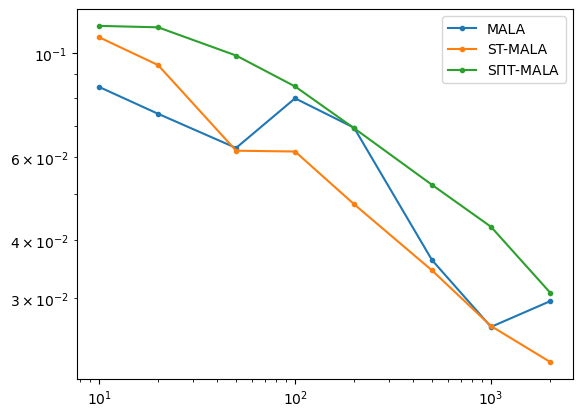

In [20]:
plt.loglog(iteration_list, res_wass_p_imq, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [21]:
#KGM
res_wass_p_centkgm = []
res_wass_q_centkgm = []
res_wass_p_thinning_centkgm = []
res_wass_q_thinning_centkgm = []

In [22]:
# KGM Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_centkgm.append(wass_p)
    res_wass_q_centkgm.append(wass_q)

    res_wass_p_thinning_centkgm.append(wass_p_thinning)
    res_wass_q_thinning_centkgm.append(wass_q_thinning)

10 0.10799494790009936
10 0.1141921837120562
20 0.07810577968598313
20 0.1502685048015165
50 0.06918865770611174
50 0.1047949881762557
100 0.061548719374578294
100 0.08797112596194377
200 0.057658791375654536
200 0.08316703527120996
500 0.045626218200320416
500 0.05633723242143238
1000 0.03901061131575814
1000 0.042157706809695474
2000 0.03082017353559626
2000 0.03494195919186324


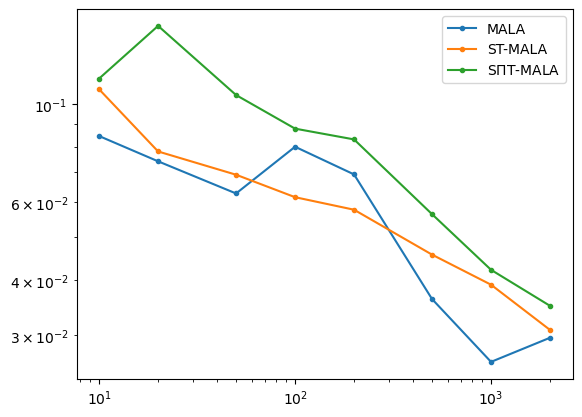

In [23]:
plt.loglog(iteration_list, res_wass_p_centkgm, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

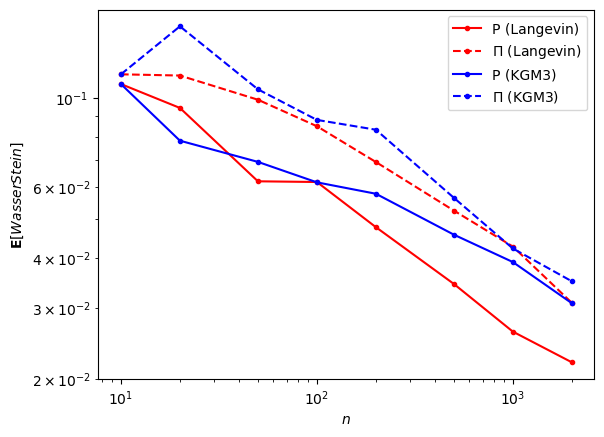

In [24]:
plt.loglog(iteration_list, res_wass_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_wass_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_wass_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$WasserStein$]')
plt.legend()